# Ingest and query data from Apache Kafka

<!--
  ~ Licensed to the Apache Software Foundation (ASF) under one
  ~ or more contributor license agreements.  See the NOTICE file
  ~ distributed with this work for additional information
  ~ regarding copyright ownership.  The ASF licenses this file
  ~ to you under the Apache License, Version 2.0 (the
  ~ "License"); you may not use this file except in compliance
  ~ with the License.  You may obtain a copy of the License at
  ~
  ~   http://www.apache.org/licenses/LICENSE-2.0
  ~
  ~ Unless required by applicable law or agreed to in writing,
  ~ software distributed under the License is distributed on an
  ~ "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
  ~ KIND, either express or implied.  See the License for the
  ~ specific language governing permissions and limitations
  ~ under the License.
  -->

This tutorial introduces you to streaming ingestion in Apache Druid using the Apache Kafka event streaming platform.
Follow along to learn how to create and load data into a Kafka topic, start ingesting data from the topic into Druid, and query results over time. This tutorial assumes you have a basic understanding of Druid ingestion, querying, and API requests.

## Prerequisites

This tutorial works with Druid 25.0.0 or later.

Launch this tutorial and all prerequisites using the `all-services` profile of the Docker Compose file for Jupyter-based Druid tutorials. For more information, see the Learn Druid repository [readme](https://github.com/implydata/learn-druid).

## Load Druid API client

To start the tutorial, run the following cell. It imports the required Python packages and defines a variable for the Druid client, and another for the SQL client used to run SQL commands.

In [1]:
import druidapi
import os
import time

if 'DRUID_HOST' not in os.environ.keys():
    druid_host=f"http://localhost:8888"
else:
    druid_host=f"http://{os.environ['DRUID_HOST']}:8888"
    
print(f"Opening a connection to {druid_host}.")
druid = druidapi.jupyter_client(druid_host)

Opening a connection to http://router:8888.


In [2]:
# Use kafka_host variable when connecting to kafka 
if 'KAFKA_HOST' not in os.environ.keys():
   kafka_host=f"http://localhost:9092"
else:
    kafka_host=f"{os.environ['KAFKA_HOST']}:9092"

# this is the kafka topic we will be working with:
topic_name = "social_media"

In [3]:
import json

# shortcuts for display and sql api's
display = druid.display
sql_client = druid.sql

# client for Data Generator API
datagen = druidapi.rest.DruidRestClient("http://datagen:9999")

# client for Druid API
rest_client = druid.rest

## Publish generated data directly to Kafka topic

In this section, you use the data generator included as part of the Docker application to generate a stream of messages. The data generator creates and send messages to a Kafka topic named `social_media`. To learn more about the Druid Data Generator, see the [project](https://github.com/implydata/druid-datagenerator) and the [data generation notebook](../99-contributing/02-datagen-intro.ipynb).

### Generate data
Run the following cells to load sample data into the `social_media` Kafka topic. The data generator sends events until it reaches 50,000 messages.

In [4]:
headers = {
  'Content-Type': 'application/json'
}

datagen_request = {
    "name": "social_stream",
    "target": { "type": "kafka", "endpoint": kafka_host, "topic": topic_name  },
    "config_file": "social/social_posts.json", 
    "total_events":50000,
    "concurrency":100
}
datagen.post("/start", json.dumps(datagen_request), headers=headers)


<Response [200]>

Check the status of the job with the following cell:

In [5]:
time.sleep(1) # avoid race between start of the job and its status being available
response = datagen.get('/status/social_stream')
response.json()

{'name': 'social_stream',
 'config_file': 'social/social_posts.json',
 'target': {'type': 'kafka',
  'endpoint': 'kafka:9092',
  'topic': 'social_media'},
 'active_sessions': 94,
 'total_records': 4417,
 'start_time': '2024-07-08 22:26:04',
 'run_time': 93.0,
 'status': 'RUNNING',
 'status_msg': 'Running, Sim Clock: 2024-07-08 22:27:37.035245'}

## Start Druid ingestion

Now that you have a new Kafka topic and data being streamed into the topic, you ingest the data into Druid by submitting a Kafka ingestion spec.
The ingestion spec describes the following:
* where to source the data to ingest (in `spec > ioConfig`),
* the datasource to ingest data into (in `spec > dataSchema > dataSource`), and
* what the data looks like (in `spec > dataSchema > dimensionsSpec`).

Other properties control how Druid aggregates and stores data. For more information, see the Druid documenation:
* [Apache Kafka ingestion](https://druid.apache.org/docs/latest/development/extensions-core/kafka-ingestion.html)
* [Ingestion spec reference](https://druid.apache.org/docs/latest/ingestion/ingestion-spec.html)

Run the following cells to define and view the Kafka ingestion spec.

In [6]:
kafka_ingestion_spec = {
    "type": "kafka",
    "spec": {
        "ioConfig": {
            "type": "kafka",
            "consumerProperties": {
                "bootstrap.servers": "kafka:9092"
            },
            "topic": "social_media",
            "inputFormat": {
                "type": "json"
            },
            "useEarliestOffset": True
        },
        "tuningConfig": {
            "type": "kafka"
        },
        "dataSchema": {
            "dataSource": "social_media",
            "timestampSpec": {
                "column": "time",
                "format": "iso"
            },
            "dimensionsSpec": {
                "dimensions": [
                    "username",
                    "post_title",
                    {
                        "type": "long",
                        "name": "views"
                    },
                    {
                        "type": "long",
                        "name": "upvotes"
                    },
                    {
                        "type": "long",
                        "name": "comments"
                    },
                    "edited"
                ]
            },
            "granularitySpec": {
                "queryGranularity": "none",
                "rollup": False,
                "segmentGranularity": "hour"
            }
        }
    }
}

Send the spec to Druid to start the streaming ingestion from Kafka:

In [7]:
headers = {
  'Content-Type': 'application/json'
}

supervisor = rest_client.post("/druid/indexer/v1/supervisor", json.dumps(kafka_ingestion_spec), headers=headers)
print(supervisor.status_code)

200


A `200` response indicates that the request was successful. You can view the running ingestion task and the new datasource in the web console's [ingestion view](http://localhost:8888/unified-console.html#ingestion).

The following cell pauses further execution until the ingestion has started and the datasource is available for querying:

In [8]:
druid.sql.wait_until_ready('social_media', verify_load_status=False)

## Query Druid datasource and visualize query results

You can now query the new datasource called `social_media`. In this section, you also visualize query results using the Matplotlib and Seaborn visualization libraries. Run the following cell import these packages.

In [9]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Run a simple query to view a subset of rows from the new datasource:

In [10]:
sql = '''
SELECT * FROM social_media LIMIT 5
'''
display.sql(sql)

__time,username,post_title,views,upvotes,comments,edited
2024-07-08T22:26:04.035Z,leon,75hg.Uj3D5!7RB4N3kxLUca6BJ7TMcuQLnuKyeFbd4xCKnK9Bkju'FFvKO7,5475,66,12,False
2024-07-08T22:26:05.035Z,mia,Bmjq_Gg0CIiS6Rkkgzt350EZt92hI;'0lI!ED3eL2mVUpy4TQSsZP.wMECsVVdV.Pli4ZA8:T!8HHSnS:SodfdoYj1482vxrM:m,12897,65,20,False
2024-07-08T22:26:05.035Z,leon,;3P;zb3PV39KAeyo:cr3IPr3:fkG5.dnXO8i5zbcRAIh'1ofrDxLG,5094,77,18,False
2024-07-08T22:26:06.035Z,jojo,"r4..!6PYv00wiO_59_Sv90Voqk3h06kvw.JDaQgCutFewIJz5hqGEs,f'gT_fyG40nBNjTV6GA7DjBtwFByhQbDlrG:Pd!HKmJpeCb9vu",394,87,14,True
2024-07-08T22:26:06.035Z,milton,jxu6WNYWpJTl5f4PYc'i2CRQEp8XYjwjNtrO0fduocDpAb3j4:0PfJx2fPJnsIfzino8uhQXG!!RF9zi40:gMbGu3b,19669,65,7,False


In this social media scenario, each incoming event represents a post on social media, for which you collect the timestamp, username, and post metadata. You are interested in analyzing the total number of upvotes for all posts, compared between users. Preview this data with the following query:

In [11]:
sql = '''
SELECT
  COUNT(post_title) as num_posts,
  SUM(upvotes) as total_upvotes,
  username
FROM social_media
GROUP BY username
ORDER BY num_posts
'''

response = sql_client.sql_query(sql)
response.show()

num_posts,total_upvotes,username
5072,350979,willow
5123,356710,leon
5268,366210,mia
5330,369408,jojo
5351,371505,gus
5372,373655,rocket
5374,373474,miette
5395,372698,milton


Visualize the total number of upvotes per user using a line plot. You sort the results by username before plotting because the order of users may vary as new results arrive.

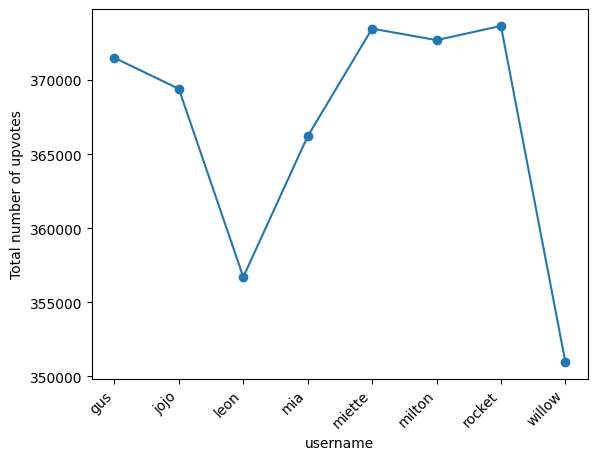

In [12]:
df = pd.DataFrame(response.json)
df = df.sort_values('username')

df.plot(x='username', y='total_upvotes', marker='o')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Total number of upvotes")
plt.gca().get_legend().remove()
plt.show()

The total number of upvotes likely depends on the total number of posts created per user. To better assess the relative impact per user, you compare the total number of upvotes (line plot) with the total number of posts.

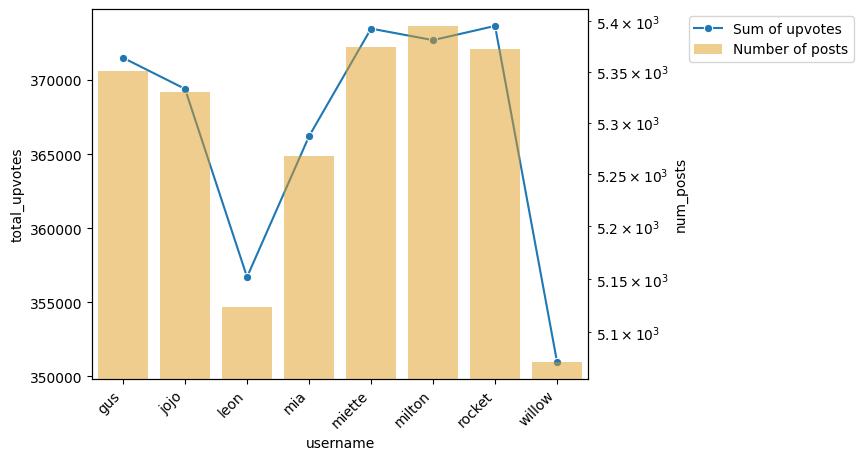

In [13]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots()
plt.xticks(rotation=45, ha='right')


sns.lineplot(
    data=df, x='username', y='total_upvotes',
    marker='o', ax=ax1, label="Sum of upvotes")
ax1.get_legend().remove()

ax2 = ax1.twinx()
sns.barplot(data=df, x='username', y='num_posts',
            order=df['username'], alpha=0.5, ax=ax2, log=True,
            color="orange", label="Number of posts")


# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, bbox_to_anchor=(1.55, 1))

You should see a correlation between total number of upvotes and total number of posts. In order to track user impact on a more equal footing, normalize the total number of upvotes relative to the total number of posts, and plot the result:

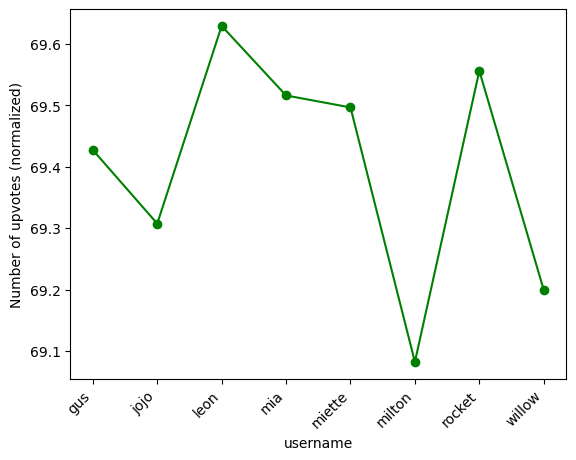

In [14]:
df['upvotes_normalized'] = df['total_upvotes']/df['num_posts']

df.plot(x='username', y='upvotes_normalized', marker='o', color='green')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of upvotes (normalized)")
plt.gca().get_legend().remove()
plt.show()

You've been working with data taken at a single snapshot in time from when you ran the last query. Run the same query again, and store the output in `response2`, which you will compare with the previous results:

In [15]:
response2 = sql_client.sql_query(sql)
response2.show()

num_posts,total_upvotes,username
6045,418728,willow
6064,422310,leon
6236,434389,mia
6298,437417,jojo
6316,439217,rocket
6331,438011,milton
6338,441235,miette
6372,442474,gus


Normalizing the data also helps you evaluate trends over time more consistently on the same plot axes. Plot the normalized data again, this time alongside the results from the previous snapshot:

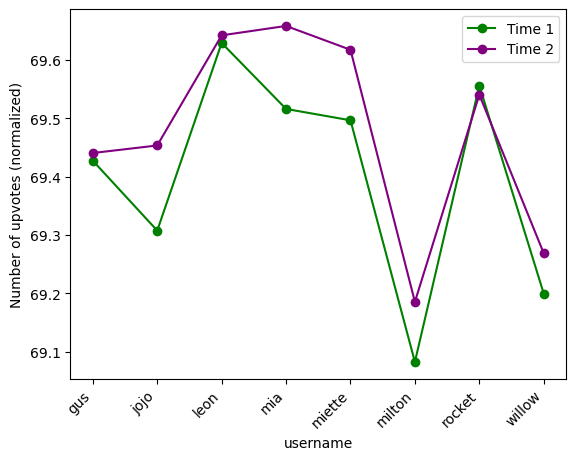

In [16]:
df2 = pd.DataFrame(response2.json)
df2 = df2.sort_values('username')
df2['upvotes_normalized'] = df2['total_upvotes']/df2['num_posts']

ax = df.plot(x='username', y='upvotes_normalized', marker='o', color='green', label="Time 1")
df2.plot(x='username', y='upvotes_normalized', marker='o', color='purple', ax=ax, label="Time 2")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of upvotes (normalized)")
plt.show()

This plot shows how some users maintain relatively consistent social media impact between the two query snapshots, whereas other users grow or decline in their influence.

## Cleanup 
The following cell stops data generation, ingestion jobs and removes the datasource from Druid.

In [17]:
print(f"Stop streaming generator: [{datagen.post('/stop/social_stream','',require_ok=False)}]")
print(f'Pause streaming ingestion: [{druid.rest.post("/druid/indexer/v1/supervisor/social_media/suspend","", require_ok=False)}]')

print(f'Shutting down running tasks ...')

tasks = druid.tasks.tasks(state='running', table='social_media')
while len(tasks)>0:
    for task in tasks:
        print(f"...stopping task [{task['id']}]")
        druid.tasks.shut_down_task(task['id'])
    tasks = druid.tasks.tasks(state='running', table='social_media')
        
print(f'Reset offsets for re-runnability: [{druid.rest.post("/druid/indexer/v1/supervisor/social_media/reset","", require_ok=False)}]')
print(f'Terminate streaming ingestion: [{druid.rest.post("/druid/indexer/v1/supervisor/social_media/terminate","", require_ok=False)}]')
print(f"Drop datasource: [{druid.datasources.drop('social_media')}]")

Stop streaming generator: [<Response [200]>]
Pause streaming ingestion: [<Response [200]>]
Shutting down running tasks ...
...stopping task [index_kafka_social_media_3b4d2f8793f5d27_bfhdaalh]
Reset offsets for re-runnability: [<Response [200]>]
Terminate streaming ingestion: [<Response [200]>]
Drop datasource: [None]


## Learn more

This tutorial showed you how to create a Kafka topic using a Python client for Kafka, send a simulated stream of data to Kafka using a data generator, and query and visualize results over time. For more information, see the following resources:

* [Apache Kafka ingestion](https://druid.apache.org/docs/latest/development/extensions-core/kafka-ingestion.html)
* [Querying data](https://druid.apache.org/docs/latest/tutorials/tutorial-query.html)
* [Tutorial: Run with Docker](https://druid.apache.org/docs/latest/tutorials/docker.html)